In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from tensorflow.keras.layers import Input, Add, Dense, Layer, BatchNormalization, Activation, concatenate
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, MaxPooling2D,BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
# Clear the session
# K.clear_session()

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class PrintShapeCallback(Callback):
    def __init__(self, model_layer_name):
        super(PrintShapeCallback, self).__init__()
        self.model_layer_name = model_layer_name

    def on_epoch_end(self, epoch, logs=None):
        # Get the output of the layer with the specified name
        layer_output = self.model.get_layer(self.model_layer_name).output
        print(f"After epoch {epoch+1}, shape of x (from layer {self.model_layer_name}): {layer_output.shape}")

print_shape_callback = PrintShapeCallback(model_layer_name='dense_1')  # Assuming 'dense_1' is the name of the Dense layer after h2(x)

class StopAtThresholdCallback(Callback):
    def __init__(self, threshold):
        super(StopAtThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.threshold:
            print(f"\nStopping training as validation loss {val_loss} is below the threshold {self.threshold}")
            self.model.stop_training = True

# callback = StopAtThresholdCallback(threshold=1e-03)
callback = StopAtThresholdCallback(threshold=1e-06)

class H1Layer(Layer):
    def __init__(self, **kwargs):
        super(H1Layer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(mean=0.0,stddev=0.05),
                                trainable=True)
        super(H1Layer, self).build(input_shape)

    def call(self, x):
        return self.b * (2 * x)
        #return (2 * x) 

class H2Layer(Layer):
    def __init__(self, **kwargs):
        super(H2Layer, self).__init__(**kwargs)

    def call(self, x, h1):
        return (2*x*(h1))-2
    
class H3Layer(Layer):
    def __init__(self, **kwargs):
        super(H3Layer, self).__init__(**kwargs)
        
    def call(self, x, h1, h2):
        return (2 * x * (h2))-(4 * h1)

class H4Layer(Layer):
    def __init__(self, **kwargs):
        super(H4Layer, self).__init__(**kwargs)

    def call(self, x, h2, h3):
        return (2*x*(h3))-(6*h2)   

class H5Layer(Layer):
    def __init__(self, **kwargs):
        super(H5Layer,self).__init__(**kwargs)

    def call(self,x, h3, h4):
        return (2*x*(h4))-(8*h3)
    
class H6Layer(Layer):
    def __init__(self, **kwargs):
        super(H6Layer,self).__init__(**kwargs)
        
    def call(self,x, h4, h5):
        return (2*x*(h5))-(10*h4)
    
class H7Layer(Layer):
    def __init__(self, **kwargs):
        super(H7Layer,self).__init__(**kwargs)
        
    def call(self,x, h5, h6):
        return (2*x*(h6))-(12*h5)

class TensorDecompositionLayer(Layer):
    def __init__(self, rank, **kwargs):
        self.rank = rank
        super(TensorDecompositionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.factors_a = self.add_weight(shape=(input_shape[-1], self.rank),
                                         initializer=RandomNormal(mean=0.0,stddev=0.05),
                                         trainable=True)
        self.factors_b = self.add_weight(shape=(self.rank, input_shape[-1]),
                                        initializer=RandomNormal(mean=0.0,stddev=0.05),
                                        trainable=True)
        super(TensorDecompositionLayer, self).build(input_shape)

    def call(self, x):
        return tf.matmul(tf.matmul(x, self.factors_a), self.factors_b)

class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.tanh(x * self.b)

2024-03-25 13:40:51.275143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-25 13:40:51.764061: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 64)                   128       ['input_1[0][0]']             
                                                                                                  
 h1_layer (H1Layer)          (None, 64)                   64        ['dense[0][0]']               
                                                                                                  
 dense_1 (Dense)             (None, 64)                   4160      ['h1_layer[0][0]']            
                                                                                              

2024-02-28 12:31:56.015782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 12:31:56.034753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-28 12:31:56.034949: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

125/125 [==============================] - 3s 4ms/step - loss: 0.1888 - val_loss: 0.1258
Epoch 2/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1249 - val_loss: 0.1259
Epoch 3/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1244 - val_loss: 0.1242
Epoch 4/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1240 - val_loss: 0.1241
Epoch 5/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1235 - val_loss: 0.1249
Epoch 6/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1219 - val_loss: 0.1220
Epoch 7/150
125/125 [==============================] - 0s 3ms/step - loss: 0.1187 - val_loss: 0.1116
Epoch 8/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0947 - val_loss: 0.0854
Epoch 9/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0840 - val_loss: 0.0815
Epoch 10/150
125/125 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0818
E

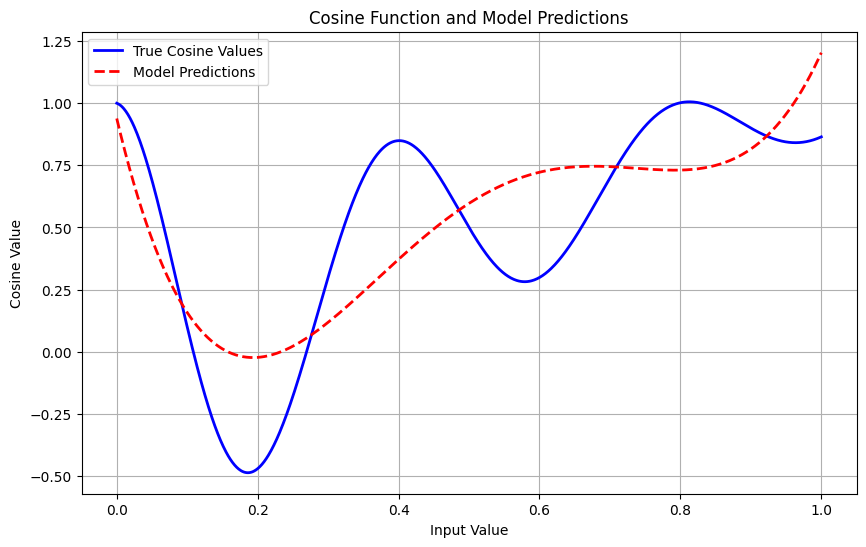

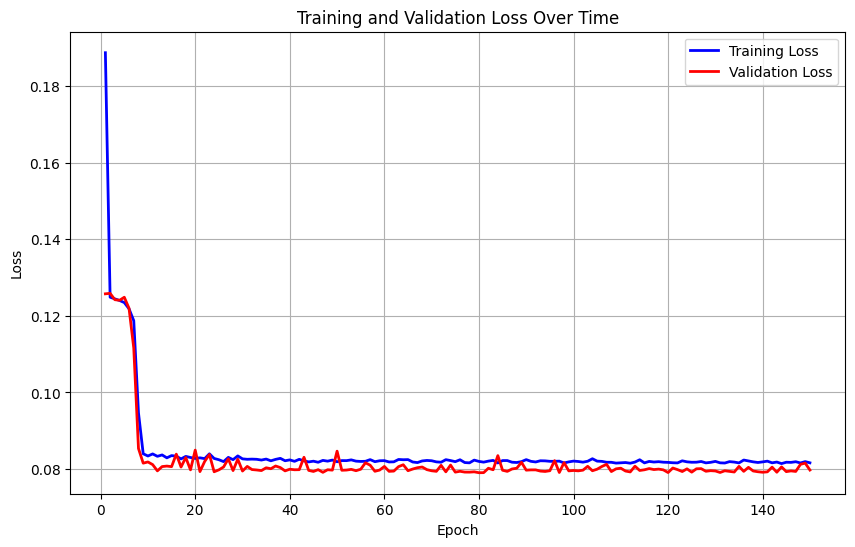

In [2]:
np.random.seed(42)
n_samples = 10000
lower_bound = 0
upper_bound = 1
# lower_bound = -10
# upper_bound = 10
def custom_function(x):
    return np.exp(-2*x) * np.cos(5*np.pi*x) + x

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = custom_function(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    h1 = H1Layer()
    h2 = H2Layer()
    h3 = H3Layer()
    h4 = H4Layer()
    h5 = H5Layer()
    h6 = H6Layer()
    h7 = H7Layer()
    #softsign
    x = Dense(filters)(x)
    x = x_h1 = h1(x)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h2 = h2(x,x_h1)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    x = x_h3 = h3(x,x_h1,x_h2)
    x = Dense(filters)(x)
    x = TensorDecompositionLayer(rank)(x)
    # x = x_h4 = h4(x,x_h2, x_h3)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    # x = x_h5 = h5(x,x_h3, x_h4)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    # x = tf.keras.activations.softsign(x)
    # x = x_h6 = h6(x,x_h4, x_h5)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)
    # x = x_h7 = h7(x,x_h5,x_h6)
    # x = Dense(filters)(x)
    # x = TensorDecompositionLayer(rank)(x)    
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)

y_true = custom_function(X_test)

y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()
#59 SECONDS
#8.5559e-06
#8.6049e-06
#8.3881e-06

# RELU

In [2]:

class Relu_With_Weight(Layer):
    def __init__(self, **kwargs):
        super(Relu_With_Weight, self).__init__(**kwargs)

    def build(self, input_shape):
        self.b = self.add_weight(shape=(input_shape[-1],),
                                initializer=RandomNormal(),
                                trainable=True)
        super(Relu_With_Weight, self).build(input_shape)

    def call(self, x):
        return K.relu(x * self.b)

2024-03-25 13:40:52.749768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 13:40:52.766995: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 13:40:52.767190: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 activation_2 (Activation)   (None, 64)                0     

s-bus-pci#L344-L355
2024-03-25 13:40:52.769288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 13:40:52.769416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-25 13:40:53.183803: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentat

13/13 [==============================] - 2s 12ms/step - loss: 0.3182 - val_loss: 0.1571
Epoch 2/150
13/13 [==============================] - 0s 4ms/step - loss: 0.1476 - val_loss: 0.1433
Epoch 3/150
13/13 [==============================] - 0s 5ms/step - loss: 0.1313 - val_loss: 0.1347
Epoch 4/150
13/13 [==============================] - 0s 5ms/step - loss: 0.1186 - val_loss: 0.1260
Epoch 5/150
13/13 [==============================] - 0s 4ms/step - loss: 0.1081 - val_loss: 0.1174
Epoch 6/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0970 - val_loss: 0.0971
Epoch 7/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0799 - val_loss: 0.0741
Epoch 8/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0677 - val_loss: 0.0663
Epoch 9/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0598 - val_loss: 0.0551
Epoch 10/150
13/13 [==============================] - 0s 5ms/step - loss: 0.0454 - val_loss: 0.0422
Epoch 11/150
13/13 [

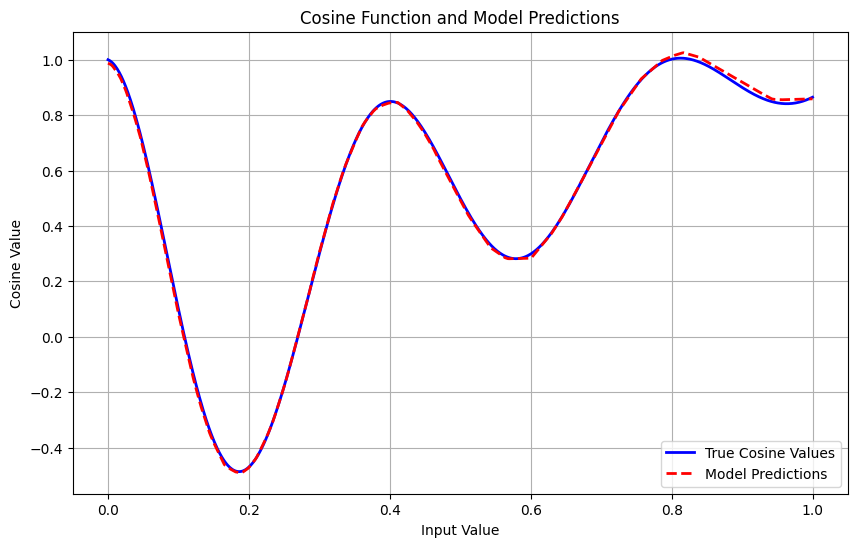

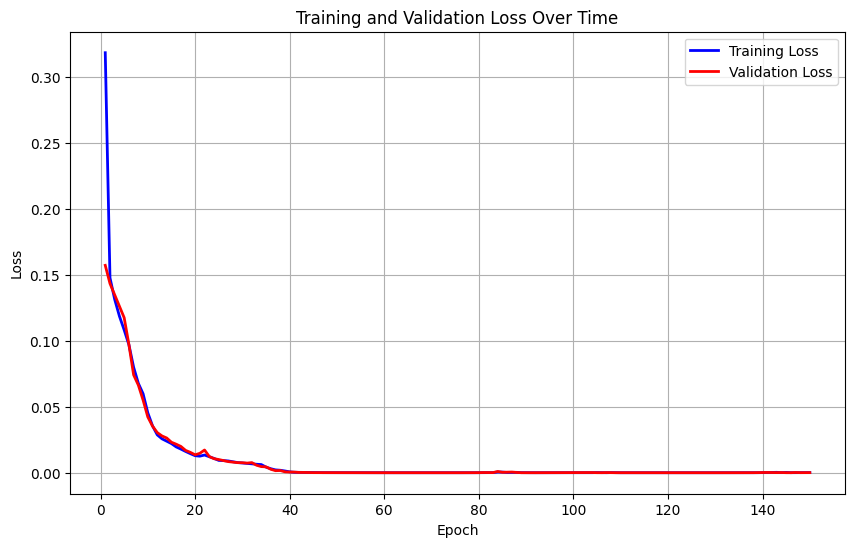

: 

: 

In [3]:
np.random.seed(42)
n_samples = 1000
lower_bound = 0
upper_bound = 1
# lower_bound = -10
# upper_bound = 10

def custom_function(x):
    return np.exp(-2*x) * np.cos(5*np.pi*x) + x

X = np.random.uniform(lower_bound, upper_bound, size=(n_samples, 1))
#X = np.arange(lower_bound, upper_bound, 0.001)
y = custom_function(X)

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def build_model(input_shape, filters):
    rank = 3
    input_layer = Input(shape=input_shape)
    x = input_layer

    modRelu = Relu_With_Weight()

    x = Dense(filters)(x)
    x = Activation("relu")(x)
    x = Dense(filters)(x)
    x = Activation("relu")(x)
    x = Dense(filters)(x)
    x = Activation("relu")(x)
    x = Dense(filters)(x)
    x = Activation("relu")(x)
    x = Dense(filters)(x)
    x = Activation("relu")(x)
    x = Dense(filters)(x)

    output_layer = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model 


input_shape = (1,)
filters = 64
modelN4 = build_model(input_shape, filters)
modelN4.summary()
optimizer = Adam(learning_rate=0.001) # Reduce learning rate
modelN4.compile(optimizer=optimizer, loss='mse')

batch_size = 64
epochs = 150

history = modelN4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val),
                    callbacks=[callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

val_loss = modelN4.evaluate(X_val, y_val, verbose=0)
print(f"Validation loss: {val_loss}")

import matplotlib.pyplot as plt

num_test_samples = 1000
X_test = np.linspace(lower_bound, upper_bound, num=num_test_samples).reshape(-1, 1)

y_true = custom_function(X_test)

y_pred = modelN4.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, label='True Cosine Values', color='b', linewidth=2)
plt.plot(X_test, y_pred, label='Model Predictions', color='r', linestyle='--', linewidth=2)
plt.xlabel('Input Value')
plt.ylabel('Cosine Value')
plt.title('Cosine Function and Model Predictions')
plt.legend()
plt.grid()
plt.show()

# Number of epochs actually trained
actual_epochs = len(history.history['loss'])

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, actual_epochs + 1), train_loss[:actual_epochs], label='Training Loss', color='b', linewidth=2)
plt.plot(range(1, actual_epochs + 1), history.history['val_loss'], label='Validation Loss', color='r', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid()
plt.show()